# Compare Read Stack

https://github.com/Elembio/AvidityManuscript2023/blob/701be395c892d00beca69693536ad600d209eec2/notebooks/compare_read_stack.ipynb

In [138]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

run_names = {
    "aviti_ngi": "AVITI CB FS (NGI)",
    "aviti_hq": "AVITI CB (HQ)",
    "xplus_sns": "NovaSeqX+ (S&S)",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/stack_reads")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = "../Manuscript/Figures/"

In [210]:
def file_to_strat(file):
    if any(s in file for s in ["G4", "pqsfinder", "random"]):
        return file.split(".")[-3][6:]
    return "_".join(file.split(".")[-3].split("_")[3:-1])

doff = []
columns = ["chr", "pos", "errors", "bases", "error_rate"]
for file in basedir.rglob("*/*.offset-error.tsv"):
    d = pd.read_csv(file, sep="\t", names=columns)
    strat = file.name.split(".")[0]
    if strat.startswith("GRCh38_SimpleRepeat_"):
        strat = "_".join(strat.split("_")[2:-1])
    d["stratification"] = strat
    d["run"] = file.parent.parent.stem
    d["cell"] = file.parent.stem
    doff.append(d)

doff = pd.concat(doff).reset_index(drop=True)

# Filter out postions -101 < pos < 100
doff = doff[(doff["pos"] <= 50) & (doff["pos"] >= -51)]

# Filter out low coverage stratifications
d = doff.groupby(["stratification", "run", "cell"], as_index=False)["bases"].sum()
low_cov = d[d["bases"] < 2*50*100]["stratification"].unique().tolist()
print("Low cov stratifications:\n -", "\n - ".join(low_cov))

#doff = doff[~doff["stratification"].isin(low_cov)]

doff["Data source"] = doff["run"].replace(run_names)
doff.head()

    

Low cov stratifications:
 - homopolymer_ge21_GC
 - triTR_50to149


chr  pos  errors  bases  error_rate       stratification       run cell  \
61  chr20  -51       0   20.0         0.0  homopolymer_ge21_GC  aviti_hq  REH   
62  chr20  -50       0   20.0         0.0  homopolymer_ge21_GC  aviti_hq  REH   
63  chr20  -49       0   20.0         0.0  homopolymer_ge21_GC  aviti_hq  REH   
64  chr20  -48       0   20.0         0.0  homopolymer_ge21_GC  aviti_hq  REH   
65  chr20  -47       0   20.0         0.0  homopolymer_ge21_GC  aviti_hq  REH   

      Data source  
61  AVITI CB (HQ)  
62  AVITI CB (HQ)  
63  AVITI CB (HQ)  
64  AVITI CB (HQ)  
65  AVITI CB (HQ)

<Axes: xlabel='bases', ylabel='stratification'>

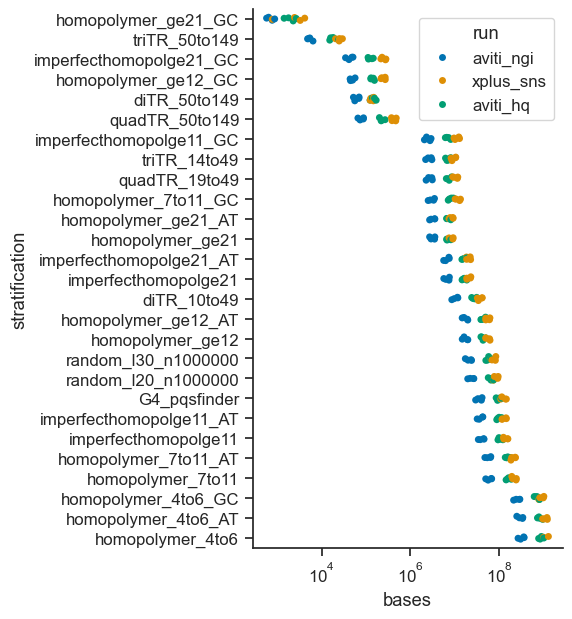

In [205]:
fig, ax = plt.subplots(figsize=(4,7))
sns.stripplot(d.sort_values(by="bases"), y="stratification", x="bases", hue="run", ax=ax, log_scale=True)

<Axes: xlabel='Position relative homopolymer_ge12', ylabel='Error rate (%)'>

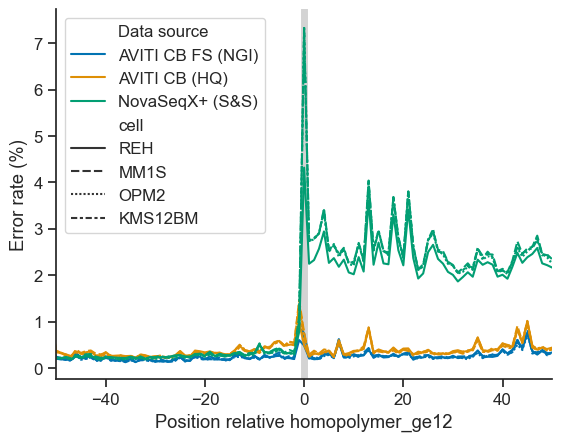

In [73]:
def plot_strat(df, stratification, bp_max=50):
    d = df[df["stratification"] == stratification]
    ax = sns.lineplot(d, x="pos", y="error_rate", hue="Data source", style="cell", hue_order=run_names.values())
    ax.set_ylabel("Error rate (%)")
    ax.set_xlabel(f"Position relative {stratification}")
    ax.axvline(0, color="lightgrey", lw=5,  zorder=-1)
    ax.set_xlim(-bp_max, bp_max)
    return ax

plot_strat(doff, "homopolymer_ge12")

<Axes: xlabel='Position relative diTR_10to49', ylabel='Error rate (%)'>

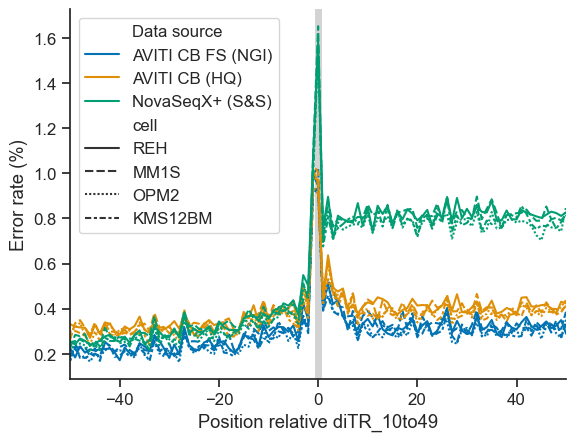

In [74]:
plot_strat(doff, "diTR_10to49")


<Axes: xlabel='Position relative triTR_14to49', ylabel='Error rate (%)'>

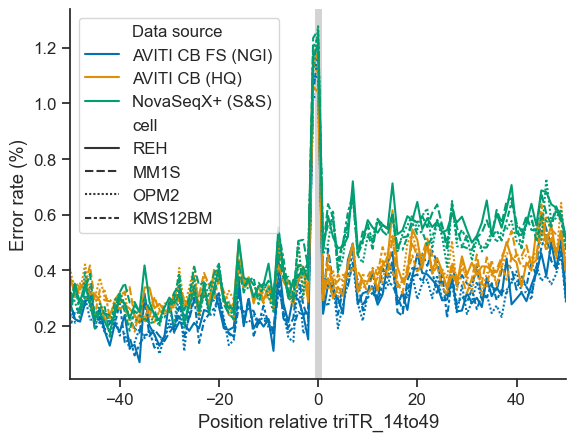

In [75]:
plot_strat(doff, "triTR_14to49")


<Axes: xlabel='Position relative quadTR_19to49', ylabel='Error rate (%)'>

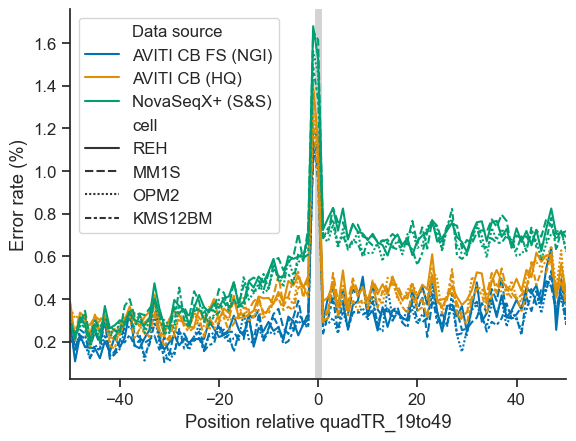

In [76]:
plot_strat(doff, "quadTR_19to49")


<Axes: xlabel='Position relative G4_pqsfinder', ylabel='Error rate (%)'>

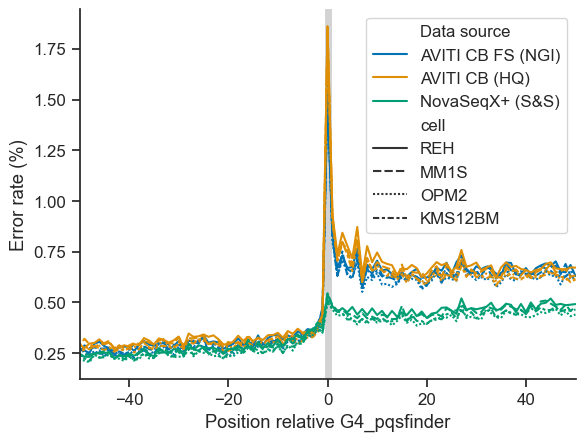

In [77]:
plot_strat(doff, "G4_pqsfinder")


<Axes: xlabel='Position relative random_l20_n1000000', ylabel='Error rate (%)'>

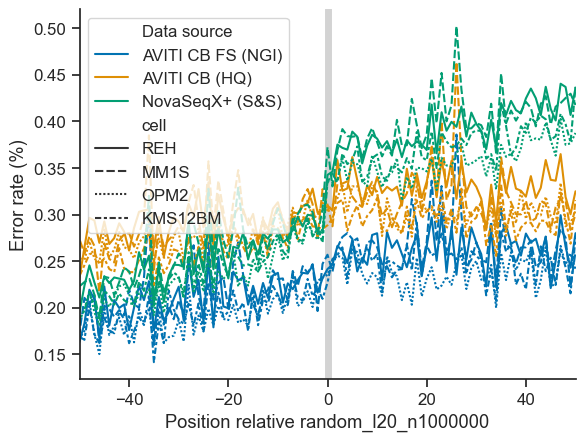

In [78]:
plot_strat(doff, "random_l20_n1000000")


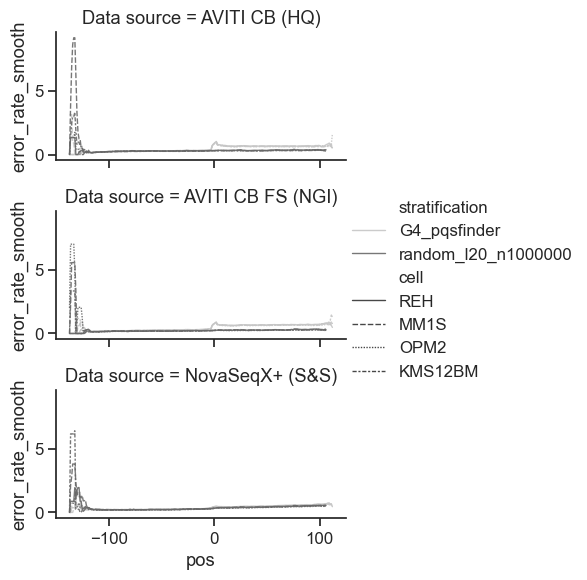

In [43]:
stratification = "G4_pqsfinder"
d = doff[doff["stratification"].isin([stratification, "random_l20_n1000000"])]
d["error_rate_smooth"] = d.groupby(["run", "cell"])["error_rate"].transform(lambda x: x.rolling(5, center=True).mean())
ax = sns.relplot(d, kind="line", x="pos", y="error_rate_smooth", row="Data source", hue="stratification", palette="Greys",
                 style="cell", aspect=2, height=2, alpha=.9, lw=1)
#ax.set_ylabel("Error rate (%)")
#ax.set_xlabel(f"Position relative {stratification}")


In [141]:
sorted(doff["stratification"].unique().tolist())

['G4_pqsfinder',
 'diTR_10to49',
 'diTR_50to149',
 'homopolymer_4to6',
 'homopolymer_4to6_AT',
 'homopolymer_4to6_GC',
 'homopolymer_7to11',
 'homopolymer_7to11_AT',
 'homopolymer_7to11_GC',
 'homopolymer_ge12',
 'homopolymer_ge12_AT',
 'homopolymer_ge12_GC',
 'homopolymer_ge21',
 'homopolymer_ge21_AT',
 'imperfecthomopolge11',
 'imperfecthomopolge11_AT',
 'imperfecthomopolge11_GC',
 'imperfecthomopolge21',
 'imperfecthomopolge21_AT',
 'imperfecthomopolge21_GC',
 'quadTR_19to49',
 'quadTR_50to149',
 'random_l20_n1000000',
 'random_l30_n1000000',
 'triTR_14to49']

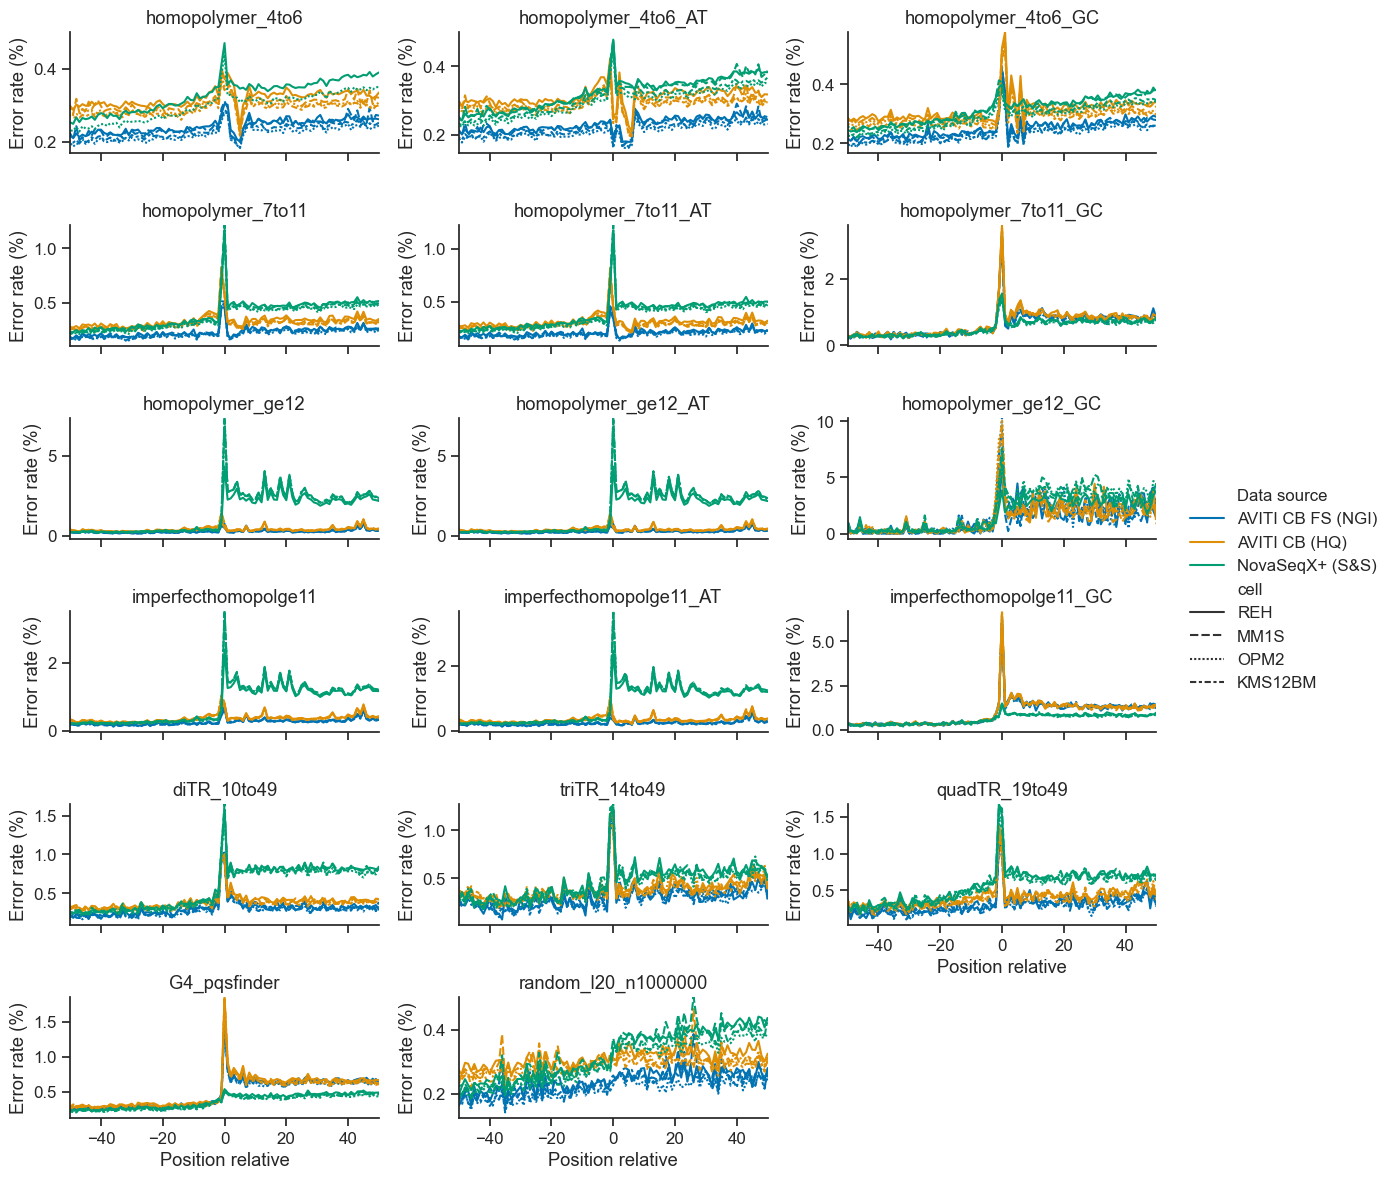

In [216]:
col_order = [
    'homopolymer_4to6',
    'homopolymer_4to6_AT',
    'homopolymer_4to6_GC',
    'homopolymer_7to11',
    'homopolymer_7to11_AT',
    'homopolymer_7to11_GC',
    'homopolymer_ge12',
    'homopolymer_ge12_AT',
    'homopolymer_ge12_GC',
    #'homopolymer_ge21',
    #'homopolymer_ge21_AT',
    #'homopolymer_ge21_GC',
    'imperfecthomopolge11',
    'imperfecthomopolge11_AT',
    'imperfecthomopolge11_GC',
    #'imperfecthomopolge21',
    #'imperfecthomopolge21_AT',
    #'imperfecthomopolge21_GC',
    'diTR_10to49',
    #'diTR_50to149',
    'triTR_14to49',
    #'triTR_50to149',
    'quadTR_19to49',
    #'quadTR_50to149',
    'G4_pqsfinder',
    'random_l20_n1000000',
    #'random_l30_n1000000',
]
d = doff[doff["stratification"].isin(col_order)]
g = sns.relplot(doff, x="pos", y="error_rate", hue="Data source", 
                hue_order=run_names.values(), col="stratification", 
                col_wrap=3, style="cell", kind="line", aspect=2, 
                col_order=col_order,
                height=2, facet_kws={"sharey": False})
g.set(ylabel="Error rate (%)", xlabel="Position relative", xlim=(-50, 50))
for s, ax in g.axes_dict.items():
    ytop = max(d[d["stratification"]==s]["error_rate"].max(), 0.5)
    ax.set_ylim(top=ytop)
g.set_titles(col_template="{col_name}")
g.tight_layout()

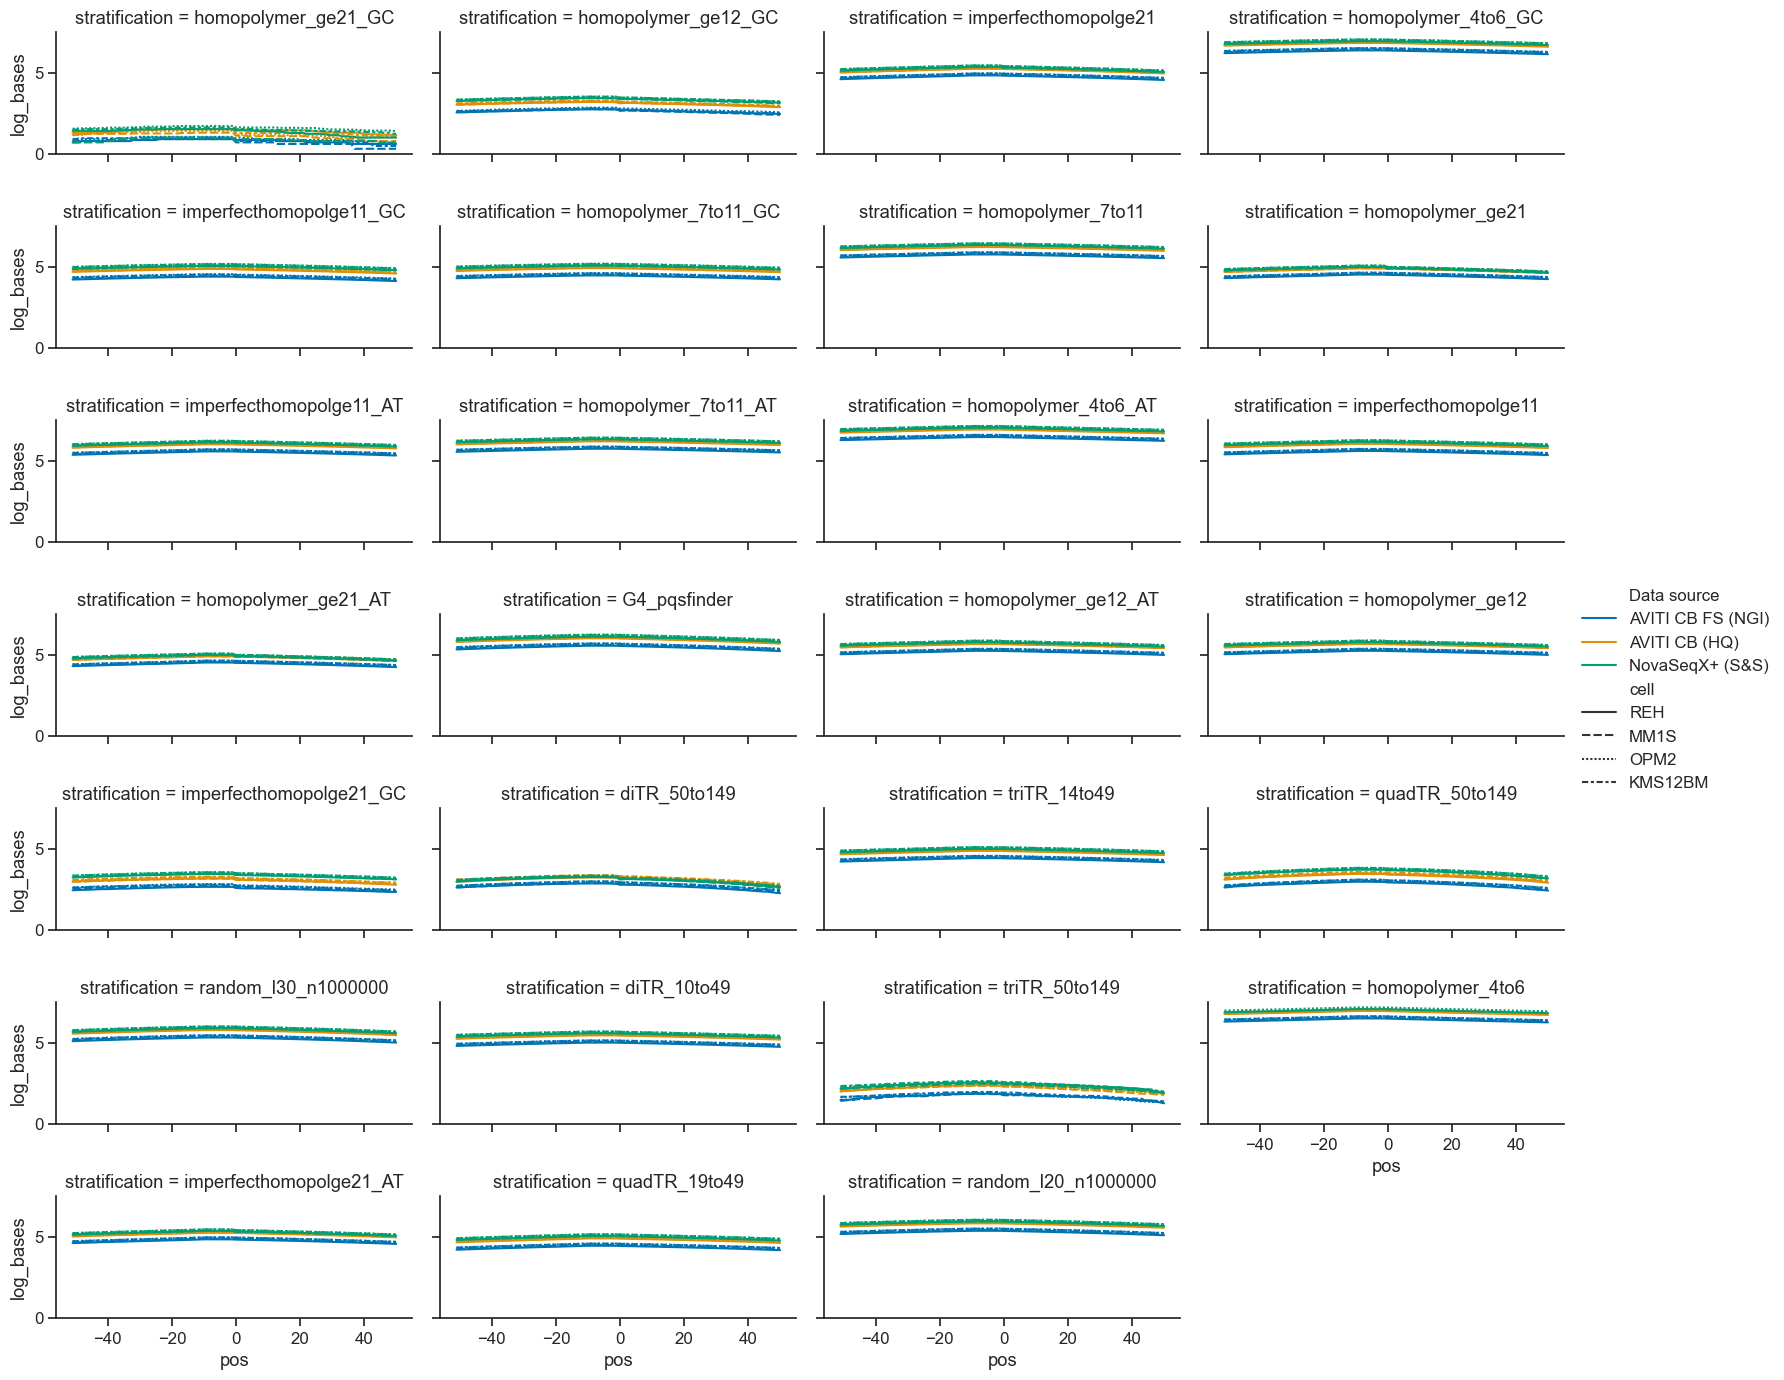

In [214]:
d = doff.copy()
d["log_bases"] = np.log10(d["bases"])
g = sns.relplot(d, x="pos", y="log_bases", hue="Data source", hue_order=run_names.values(), col="stratification", 
                col_wrap=4, style="cell", kind="line", aspect=2, height=2, facet_kws={"sharey": True})
#g.set(ylabel="Error rate (%)", xlabel="Position relative")


In [166]:
sns.color_palette("colorblind", as_cmap=True)

['#0173B2',
 '#DE8F05',
 '#029E73',
 '#D55E00',
 '#CC78BC',
 '#CA9161',
 '#FBAFE4',
 '#949494',
 '#ECE133',
 '#56B4E9']

In [169]:
dict(d[d["stratification"] == "random_l30_n1000000"].groupby("Data source")["error_rate"].mean())

{'AVITI CB (HQ)': np.float64(0.3022490940329483),
 'AVITI CB FS (NGI)': np.float64(0.2358807012830515),
 'NovaSeqX+ (S&S)': np.float64(0.3320285404970291)}

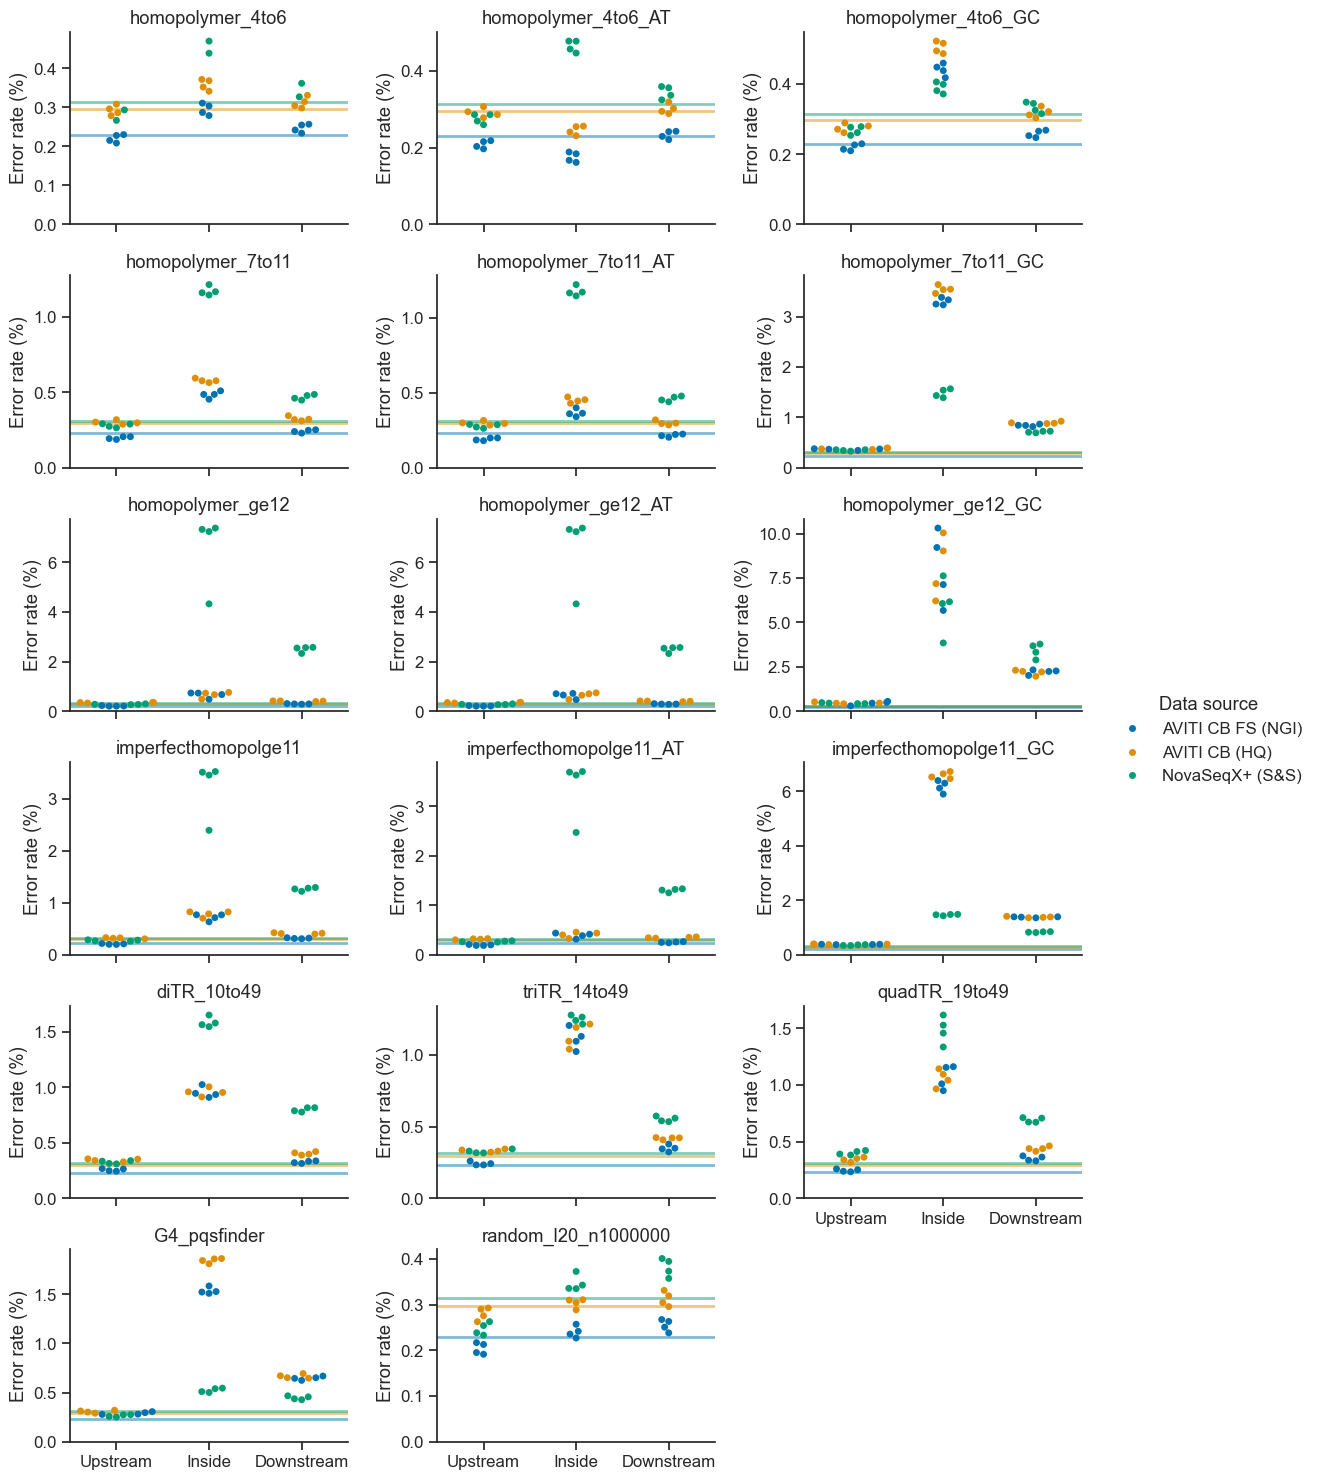

In [224]:
d = doff[doff["stratification"].isin(col_order)]
d["location"] = pd.cut(d["pos"], bins=[-51, -1, 0, 50], labels=["Upstream", "Inside", "Downstream"])
d = d.groupby(["stratification", "location", "Data source", "cell"]).agg({"error_rate": "mean"}).reset_index()
g = sns.catplot(d, x="location", y="error_rate", hue="Data source", kind="swarm", 
                col="stratification", col_order=col_order,
                col_wrap=3, aspect=1.5, height=2.5, sharey=False, 
                hue_order=run_names.values())
g.set(ylabel="Error rate (%)", xlabel="")

data_to_mean = dict(doff[doff["stratification"] == "random_l20_n1000000"].groupby("Data source")["error_rate"].mean())
colors = sns.color_palette("colorblind", as_cmap=True)
mean_to_color = {data_to_mean[d]: color for d, color in zip(run_names.values(), colors)}


for s, ax in g.axes_dict.items():
    #ytop = max(d[d["stratification"]==s]["error_rate"].max()*1.05, 1)
    ytop = d[d["stratification"]==s]["error_rate"].max()*1.05
    ax.set_ylim(bottom=0, top=ytop)
    for mean, color in mean_to_color.items():
        ax.axhline(y=mean, color=color, lw=2, zorder=-1, alpha=0.5)
g.set_titles(col_template="{col_name}", zorder=-1)
g.tight_layout()

In [83]:
list(doff["stratification"].unique())

['homopolymer_ge12_GC',
 'imperfecthomopolge21',
 'imperfecthomopolge11_GC',
 'homopolymer_7to11_GC',
 'homopolymer_7to11',
 'homopolymer_ge21',
 'imperfecthomopolge11_AT',
 'homopolymer_7to11_AT',
 'imperfecthomopolge11',
 'homopolymer_ge21_AT',
 'G4_pqsfinder',
 'homopolymer_ge12_AT',
 'homopolymer_ge12',
 'imperfecthomopolge21_GC',
 'diTR_50to149',
 'triTR_14to49',
 'quadTR_50to149',
 'random_l30_n1000000',
 'diTR_10to49',
 'imperfecthomopolge21_AT',
 'quadTR_19to49',
 'random_l20_n1000000']

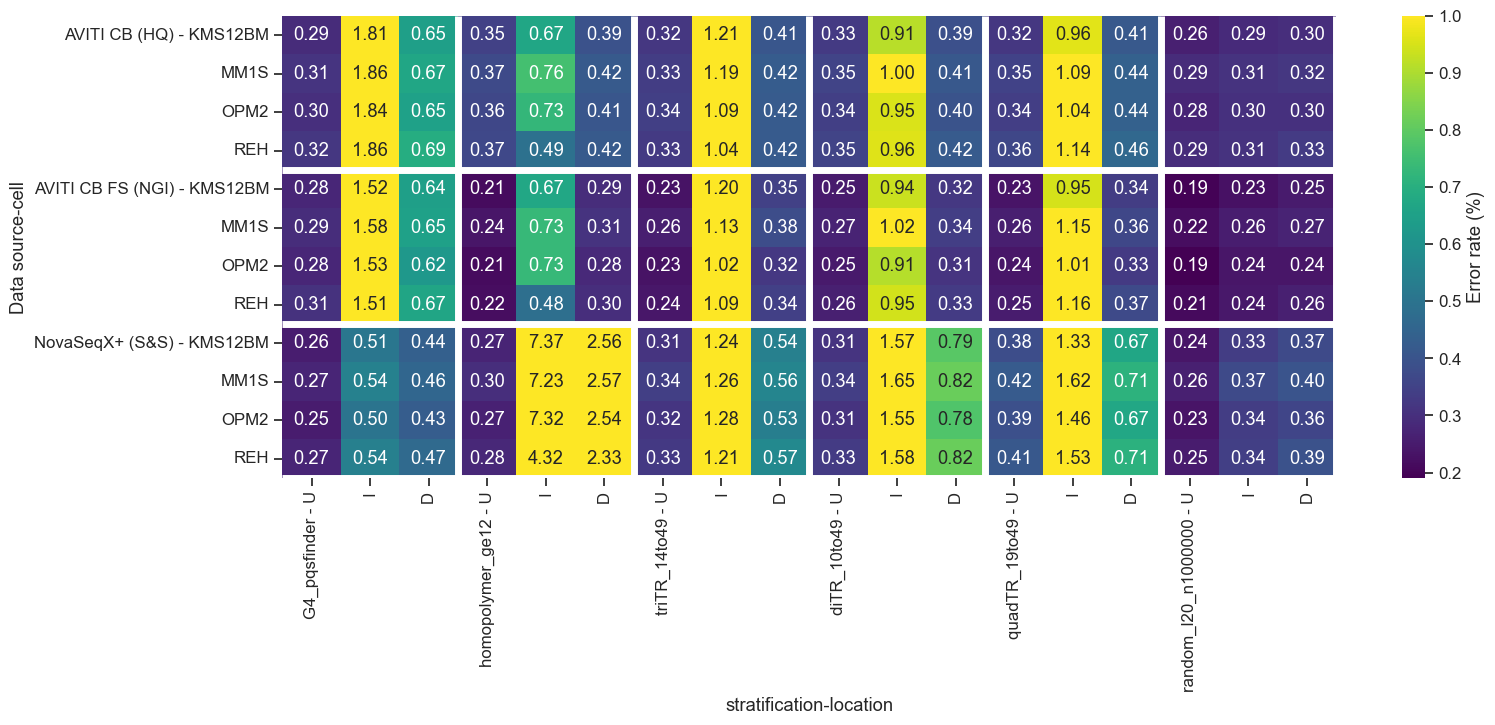

In [206]:
strats = [
    'diTR_10to49',
    'triTR_14to49',
    'quadTR_19to49',
    'G4_pqsfinder',
    'homopolymer_ge12',
    'random_l20_n1000000',
    #'random_l30_n1000000',  
]

d = doff[doff["stratification"].isin(strats)].copy()
#d = d.sort_values("stratification")
d["location"] = pd.cut(d["pos"], bins=[-101, -1, 0, 100], labels=["U", "I", "D"])
d = d.groupby(["stratification", "location", "Data source", "cell"], sort=False).agg({"error_rate": "mean"}).reset_index()
d = d.pivot(index=["Data source", "cell"], columns=["stratification", "location"], values="error_rate")
# Plot heatmap

fig, ax = plt.subplots(figsize=(17, 6))
ax = sns.heatmap(d, cmap="viridis", cbar_kws={"label": "Error rate (%)"}, square=False, vmax=1, annot=True, 
                 fmt=".2f", ax=ax)

def map_index(index):
    mapping = {}
    for i1, i2 in index:
        mapping.setdefault(i1, [])
        mapping[i1].append(i2)
    return mapping

ylabel_mapping = map_index(d.index)
xlabel_mapping = map_index(d.columns)

def get_labels_and_lines(mapping, center=False):
    labels = []
    lines = []
    for key, values in mapping.items():
        values[0] = f"{key} - {values[0]}"
        
        labels.extend(values)
        if lines:
            lines.append(len(values) + lines[-1])
        else:
            lines.append(len(values))

    return labels, lines

ylabels, hlines = get_labels_and_lines(ylabel_mapping)
xlabels, vlines = get_labels_and_lines(xlabel_mapping)

ax.hlines(hlines, xmin=0, xmax=20, color="white", linewidth=5)
_ = ax.set_yticklabels(ylabels)
ax.vlines(vlines, ymin=0, ymax=20, color="white", linewidth=5)
_ = ax.set_xticklabels(xlabels, rotation=90)


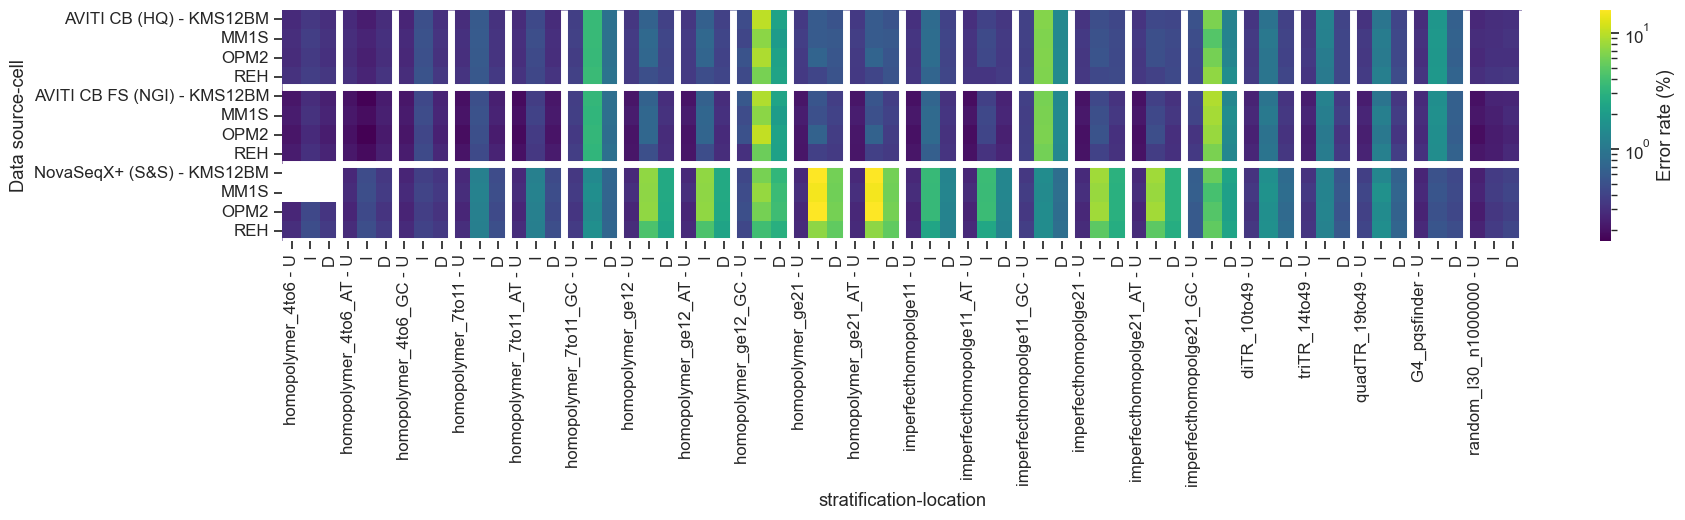

In [207]:
from matplotlib.colors import LogNorm
d = doff[doff["stratification"].isin(col_order)]

d["location"] = pd.cut(
    d["pos"], 
    bins=[-51, -1, 0, 50], 
    labels=["U", "I", "D"]
)
d["stratification"] = pd.Categorical(d["stratification"], col_order)
d = d.sort_values("stratification")
d = d.groupby(["stratification", "location", "Data source", "cell"], sort=False).agg(
    {"error_rate": "mean"}).reset_index()

d = d.pivot(
    index=["Data source", "cell"], 
    columns=["stratification", "location"], 
    values="error_rate"
)
# Plot heatmap

fig, ax = plt.subplots(figsize=(20, 3))
ax = sns.heatmap(d, cmap="viridis", cbar_kws={"label": "Error rate (%)"}, 
                 square=False, ax=ax, norm=LogNorm())

def map_index(index):
    mapping = {}
    for i1, i2 in index:
        mapping.setdefault(i1, [])
        mapping[i1].append(i2)
    return mapping

ylabel_mapping = map_index(d.index)
xlabel_mapping = map_index(d.columns)

def get_labels_and_lines(mapping, center=False):
    labels = []
    lines = []
    for key, values in mapping.items():
        values[0] = f"{key} - {values[0]}"
        
        labels.extend(values)
        if lines:
            lines.append(len(values) + lines[-1])
        else:
            lines.append(len(values))

    return labels, lines

ylabels, hlines = get_labels_and_lines(ylabel_mapping)
xlabels, vlines = get_labels_and_lines(xlabel_mapping)

ax.hlines(hlines, xmin=0, xmax=d.shape[1], color="white", linewidth=5)
_ = ax.set_yticklabels(ylabels)
ax.vlines(vlines, ymin=0, ymax=d.shape[0], color="white", linewidth=5)
_ = ax.set_xticklabels(xlabels, rotation=90)


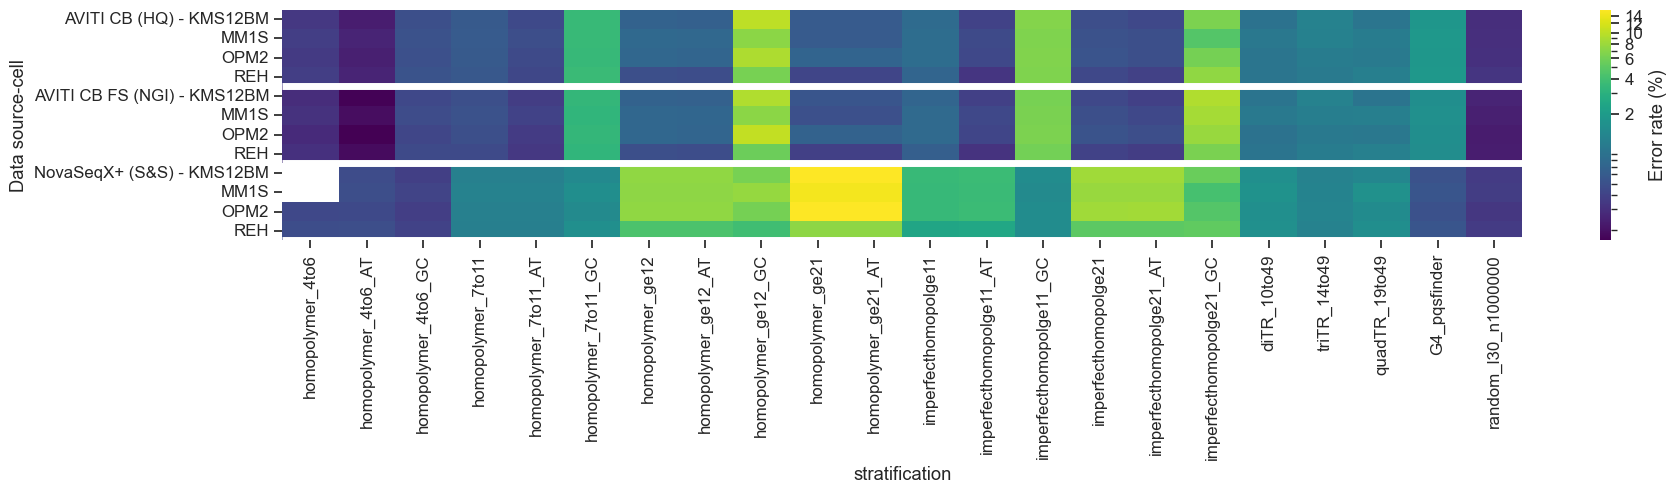

In [208]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

d = doff[(doff["stratification"].isin(col_order)) & (doff["pos"] == 0)]
d["stratification"] = pd.Categorical(d["stratification"], col_order)
d = d.sort_values("stratification")
d = d.groupby(["stratification", "Data source", "cell"], sort=False).agg(
    {"error_rate": "mean"}).reset_index()

d = d.pivot(
    index=["Data source", "cell"], 
    columns="stratification", 
    values="error_rate"
)
# Plot heatmap

fig, ax = plt.subplots(figsize=(20, 3))
ax = sns.heatmap(d, cmap="viridis", cbar_kws={"label": "Error rate (%)", 'ticks':MaxNLocator(10), 'format':'%.f'}, 
                 square=False, ax=ax, vmin=0.5, norm=LogNorm())

def map_index(index):
    mapping = {}
    for i1, i2 in index:
        mapping.setdefault(i1, [])
        mapping[i1].append(i2)
    return mapping

ylabel_mapping = map_index(d.index)

def get_labels_and_lines(mapping, center=False):
    labels = []
    lines = []
    for key, values in mapping.items():
        values[0] = f"{key} - {values[0]}"
        
        labels.extend(values)
        if lines:
            lines.append(len(values) + lines[-1])
        else:
            lines.append(len(values))

    return labels, lines

ylabels, hlines = get_labels_and_lines(ylabel_mapping)

ax.hlines(hlines, xmin=0, xmax=d.shape[1], color="white", linewidth=5)
_ = ax.set_yticklabels(ylabels)
#ax.vlines(vlines, ymin=0, ymax=d.shape[0], color="white", linewidth=5)
#_ = ax.set_xticklabels(xlabels, rotation=90)


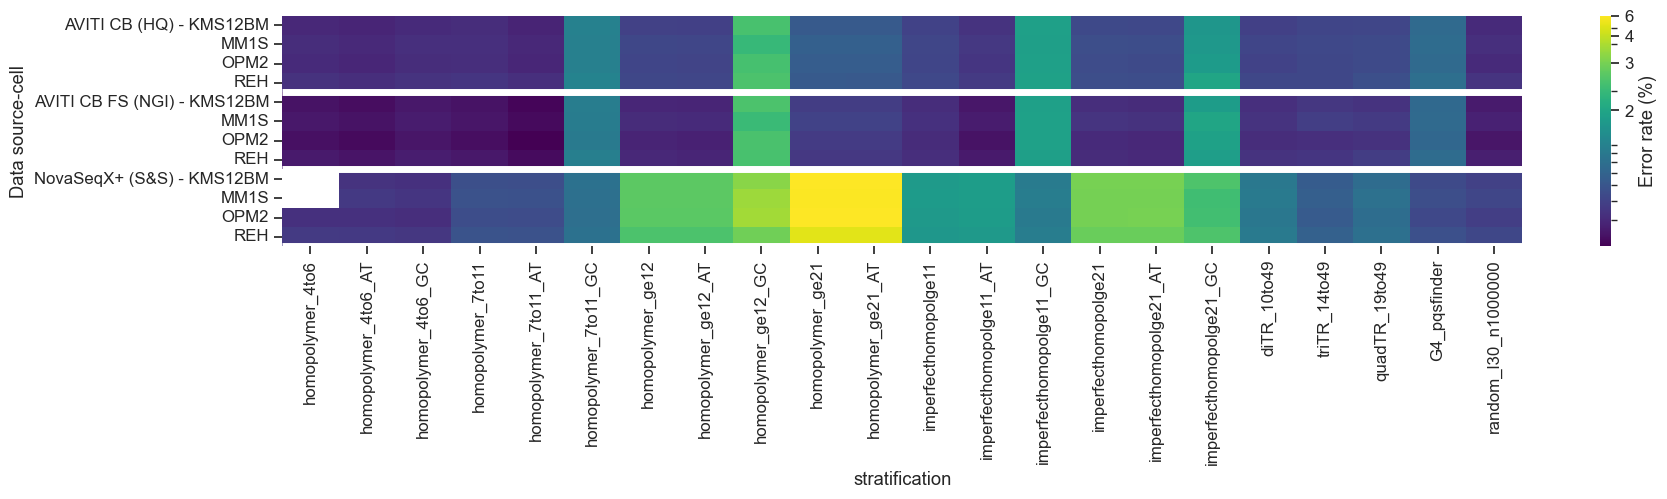

In [203]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

d = doff[(doff["stratification"].isin(col_order)) & (doff["pos"] > 0)]
d["stratification"] = pd.Categorical(d["stratification"], col_order)
d = d.sort_values("stratification")
d = d.groupby(["stratification", "Data source", "cell"], sort=False).agg(
    {"error_rate": "mean"}).reset_index()

d = d.pivot(
    index=["Data source", "cell"], 
    columns="stratification", 
    values="error_rate"
)
# Plot heatmap

fig, ax = plt.subplots(figsize=(20, 3))
ax = sns.heatmap(d, cmap="viridis", cbar_kws={"label": "Error rate (%)", 'ticks':MaxNLocator(4), 'format':'%.f'}, 
                 square=False, ax=ax, vmin=0.5, norm=LogNorm())

def map_index(index):
    mapping = {}
    for i1, i2 in index:
        mapping.setdefault(i1, [])
        mapping[i1].append(i2)
    return mapping

ylabel_mapping = map_index(d.index)

def get_labels_and_lines(mapping, center=False):
    labels = []
    lines = []
    for key, values in mapping.items():
        values[0] = f"{key} - {values[0]}"
        
        labels.extend(values)
        if lines:
            lines.append(len(values) + lines[-1])
        else:
            lines.append(len(values))

    return labels, lines

ylabels, hlines = get_labels_and_lines(ylabel_mapping)

ax.hlines(hlines, xmin=0, xmax=d.shape[1], color="white", linewidth=5)
_ = ax.set_yticklabels(ylabels)
#ax.vlines(vlines, ymin=0, ymax=d.shape[0], color="white", linewidth=5)
#_ = ax.set_xticklabels(xlabels, rotation=90)


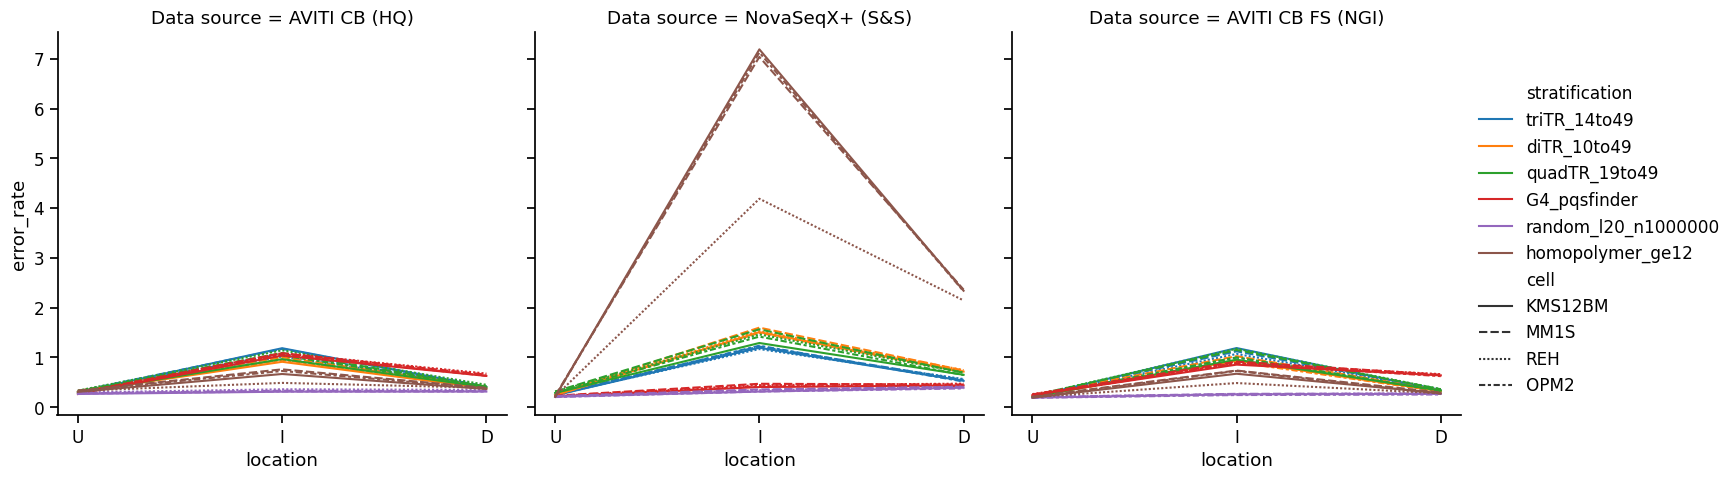

In [ ]:
strats = [
    'diTR_10to49',
    'triTR_14to49',
    'quadTR_19to49',
    'G4_pqsfinder',
    'homopolymer_ge12',
    'random_l20_n1000000',
    #'random_l30_n1000000',  
]

d = doff[doff["stratification"].isin(strats)].copy()
#d = d.sort_values("stratification")
d["location"] = pd.cut(d["pos"], bins=[-101, -1, 0, 100], labels=["U", "I", "D"])
d = d.groupby(["stratification", "location", "Data source", "cell"], sort=False).agg({"error_rate": "mean"}).reset_index()

sns.relplot(kind="line", data=d, x="location", y="error_rate", hue="stratification", col="Data source", style="cell")

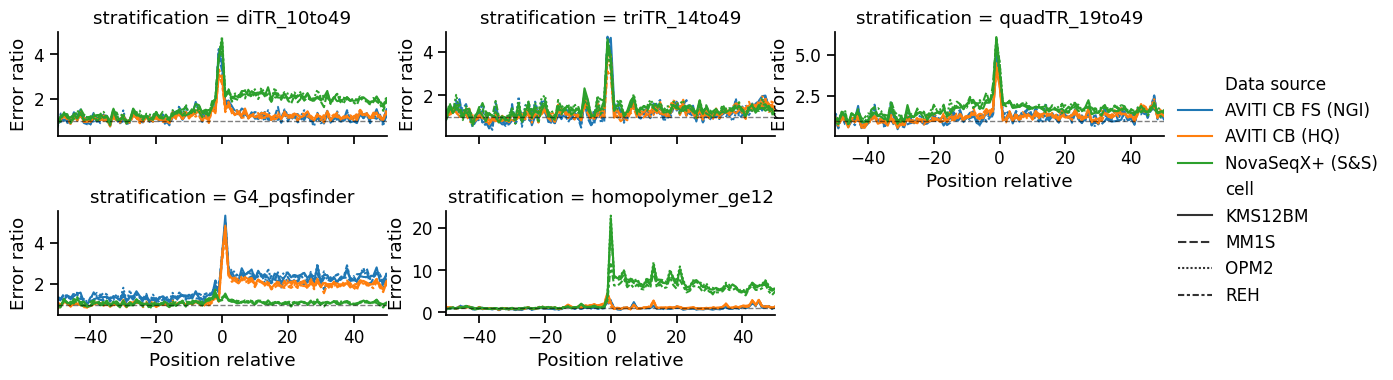

In [207]:
dnorm = doff.copy()
dnorm = dnorm.pivot(index=["Data source", "cell", "pos"], columns="stratification", values="error_rate")
dnorm = dnorm.div(dnorm["random_l30_n1000000"], axis=0)

dnorm = dnorm.melt(value_vars=strats, var_name="stratification", value_name="error_ratio", ignore_index=False).reset_index()

g = sns.relplot(dnorm, x="pos", y="error_ratio", hue="Data source", hue_order=run_names.values(), col="stratification", 
                col_wrap=3, style="cell", kind="line", aspect=2, height=2, facet_kws={"sharey": False})

g.set(ylabel="Error ratio", xlabel="Position relative", xlim=(-50, 50))

# Add a line at 1
for ax in g.axes.flat:
    ax.axhline(1, ls="--", color="black", lw=1, alpha=.5)



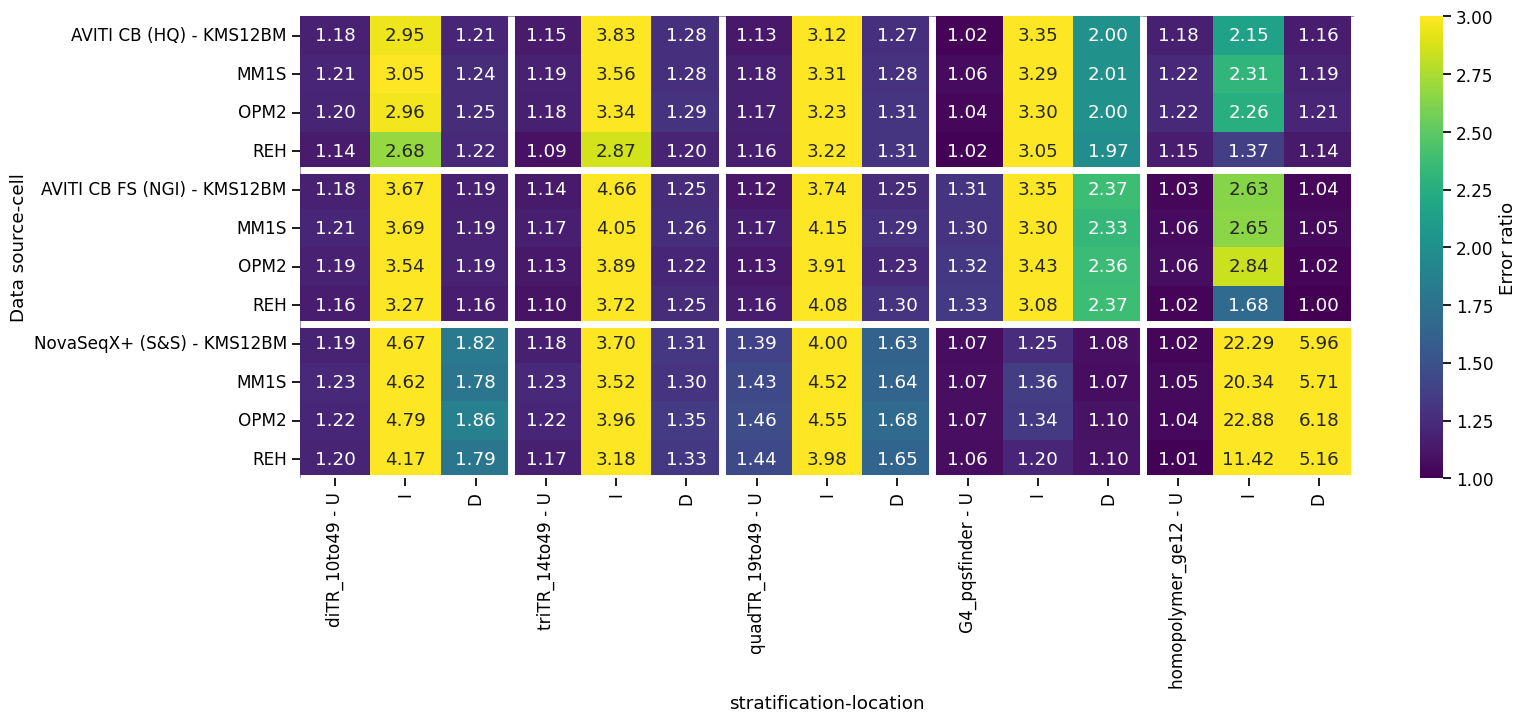

In [210]:
strats = [
    'diTR_10to49',
    'triTR_14to49',
    'quadTR_19to49',
    'G4_pqsfinder',
    'homopolymer_ge12',
    #'random_l20_n1000000',
    #'random_l30_n1000000',  
]

d = dnorm.copy()
#d = d.sort_values("stratification")
d["location"] = pd.cut(d["pos"], bins=[-101, -1, 0, 100], labels=["U", "I", "D"])
d = d.groupby(["stratification", "location", "Data source", "cell"], sort=False).agg({"error_ratio": "mean"}).reset_index()
d = d.pivot(index=["Data source", "cell"], columns=["stratification", "location"], values="error_ratio")
# Plot heatmap

fig, ax = plt.subplots(figsize=(17, 6))
ax = sns.heatmap(d, cmap="viridis", cbar_kws={"label": "Error ratio"}, square=False, vmin=1, vmax=3, annot=True, 
                 fmt=".2f", ax=ax)

def map_index(index):
    mapping = {}
    for i1, i2 in index:
        mapping.setdefault(i1, [])
        mapping[i1].append(i2)
    return mapping

ylabel_mapping = map_index(d.index)
xlabel_mapping = map_index(d.columns)

def get_labels_and_lines(mapping, center=False):
    labels = []
    lines = []
    for key, values in mapping.items():
        values[0] = f"{key} - {values[0]}"
        
        labels.extend(values)
        if lines:
            lines.append(len(values) + lines[-1])
        else:
            lines.append(len(values))

    return labels, lines

ylabels, hlines = get_labels_and_lines(ylabel_mapping)
xlabels, vlines = get_labels_and_lines(xlabel_mapping)

ax.hlines(hlines, xmin=0, xmax=20, color="white", linewidth=5)
_ = ax.set_yticklabels(ylabels)
ax.vlines(vlines, ymin=0, ymax=20, color="white", linewidth=5)
_ = ax.set_xticklabels(xlabels, rotation=90)


In [68]:
fasta = "/Users/pontus.hojer/analysis/references/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna"

def get_interval_type(x):
    chr, pos = x.split(":")
    start, end = pos.split("-")
    start = int(start)
    end = int(end)

    with pysam.Fastafile(fasta) as f:
        seq = f.fetch(reference=chr, start=start, end=end)
    
    if len(set(seq)) != 1:
        return np.nan
    base = seq[0]
    return "GC" if (base in {"G", "C"}) else "AT"

def region_length(x):
    chr, pos = x.split(":")
    start, end = pos.split("-")
    return int(end) - int(start)

dint = []

columns = "interval,interval_coord,before_coverage,total_before_error,total_before_base,error_rate_before,after_coverage,total_after_error,total_after_base,error_rate_after".split(",")

for file in glob.glob("*.interval-error.tsv"):
    print(file)
    d = pd.read_csv(file, sep="\t", names=columns)
    d["run"] = "_".join(file.split("/")[-1].split("_")[:2])
    d["cell"] = file.split("/")[-1].split("_")[2].split(".")[0]
    d["stratification"] = file_to_strat(file)
    d = d[(d["before_coverage"] > 0) & (d["after_coverage"] > 0)]
    dint.append(d)

dint = pd.concat(dint).reset_index(drop=True)
dint["length"] = dint["interval_coord"].apply(region_length)
#dint["type"] = dint["interval_coord"].apply(get_interval_type)
dint["Data source"] = dint["run"].replace(run_names)
#doff = doff[
#    (~doff["error_rate"].isna()) &\
#    (doff["bases"] > 100)
#]

dint.head()

aviti_ngi_MM1S.chr20_G4.interval-error.tsv
aviti_hq_REH.chr20_random_l30_n1000000.interval-error.tsv
aviti_ngi_KMS12BM.chr20_GRCh38_SimpleRepeat_imperfecthomopolge11_GC_slop5.interval-error.tsv
aviti_hq_KMS12BM.chr20_GRCh38_SimpleRepeat_imperfecthomopolge11_slop5.interval-error.tsv
aviti_hq_KMS12BM.chr20_GRCh38_SimpleRepeat_quadTR_19to49_slop5.interval-error.tsv
aviti_ngi_MM1S.mapq60_chr20_GRCh38_SimpleRepeat_diTR_10to49_slop5.interval-error.tsv
aviti_hq_MM1S.chr20_GRCh38_SimpleRepeat_imperfecthomopolge11_slop5.interval-error.tsv
aviti_hq_OPM2.chr20_random_l30_n1000000.interval-error.tsv
xplus_sns_MM1S.mapq60_chr20_GRCh38_SimpleRepeat_quadTR_19to49_slop5.interval-error.tsv
xplus_sns_KMS12BM.chr20_GRCh38_SimpleRepeat_imperfecthomopolge11_AT_slop5.interval-error.tsv
aviti_ngi_MM1S.chr20_GRCh38_SimpleRepeat_diTR_10to49_slop5.interval-error.tsv
aviti_ngi_KMS12BM.chr20_G4_pqsfinder.interval-error.tsv
aviti_ngi_KMS12BM.chr20_GRCh38_SimpleRepeat_homopolymer_ge12_slop5.interval-error.tsv
aviti

interval       interval_coord  before_coverage  total_before_error  \
0         1  chr20:128226-128248                2                   0   
1         2  chr20:135831-135852                3                   2   
2         5  chr20:201254-201279               18                   5   
3         6  chr20:206065-206085                9                   4   
4         7  chr20:221290-221351                2                   0   

   total_before_base  error_rate_before  after_coverage  total_after_error  \
0                 81           0.000000               2                  0   
1                277           0.722022               3                  1   
2               1153           0.433651              18                  1   
3                736           0.543478               9                  1   
4                142           0.000000               2                  0   

   total_after_base  error_rate_after        run  cell stratification  length  \
0               153          0.000000  aviti_ngi  MM1S             G4      22   
1                77          1.298701  aviti_ngi  MM1S             G4      21   
2               899          0.111235  aviti_ngi  MM1S             G4      25   
3               335          0.298507  aviti_ngi  MM1S             G4      20   
4                 2          0.000000  aviti_ngi  MM1S             G4      61   

         Data source  
0  AVITI CB FS (NGI)  
1  AVITI CB FS (NGI)  
2  AVITI CB FS (NGI)  
3  AVITI CB FS (NGI)  
4  AVITI CB FS (NGI)

In [69]:
len(dint)

4027473

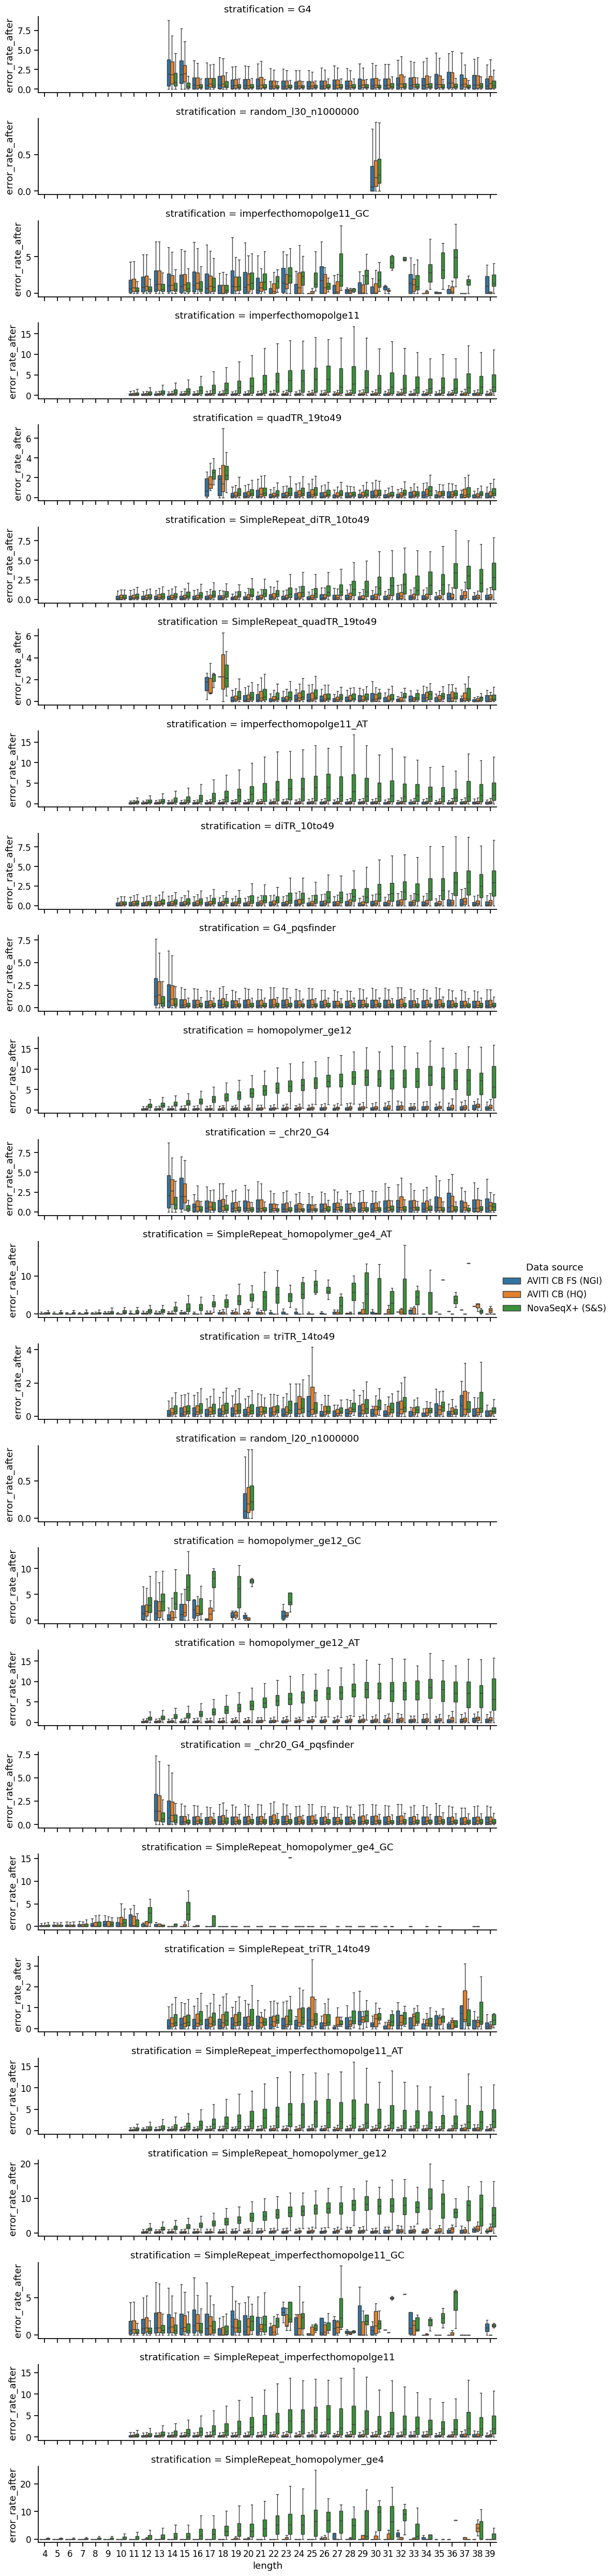

In [70]:
d = dint[(dint["length"] < 40)]
#fig, ax = plt.subplots(figsize=(12,4))
g = sns.catplot(d, kind="box", x="length", y="error_rate_after", hue="Data source", showfliers=False, row="stratification", sharey=False, aspect=5, 
                height=2, hue_order=run_names.values())
#ax.set_ylabel("Error rate for bases after (%)")
#ax.set_xlabel("Homopolymer length (bp)")

Text(0.5, 0, 'Homopolymer length (bp)')

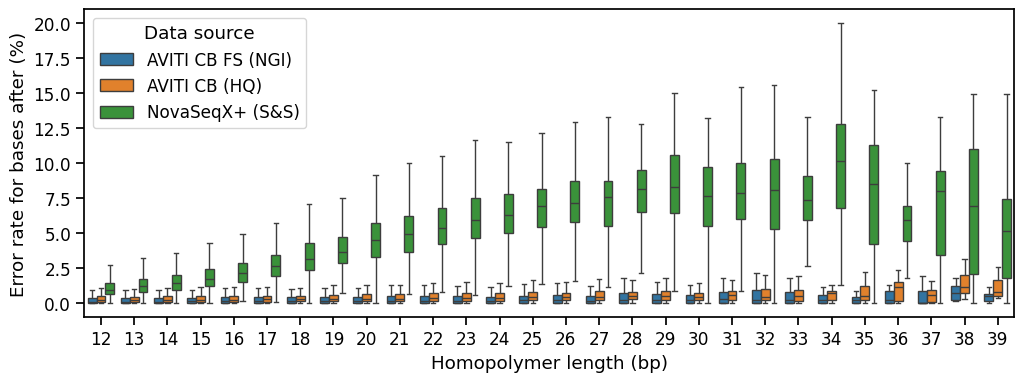

In [ ]:
d = dint[(dint["length"] < 40) & (dint["stratification"] == "homopolymer_ge12")]
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.boxplot(d, x="length", y="error_rate_after", hue="Data source", showfliers=False, ax=ax, hue_order=run_names.values())
ax.set_ylabel("Error rate for bases after (%)")
ax.set_xlabel("Homopolymer length (bp)")

(-1.0, 21.0)

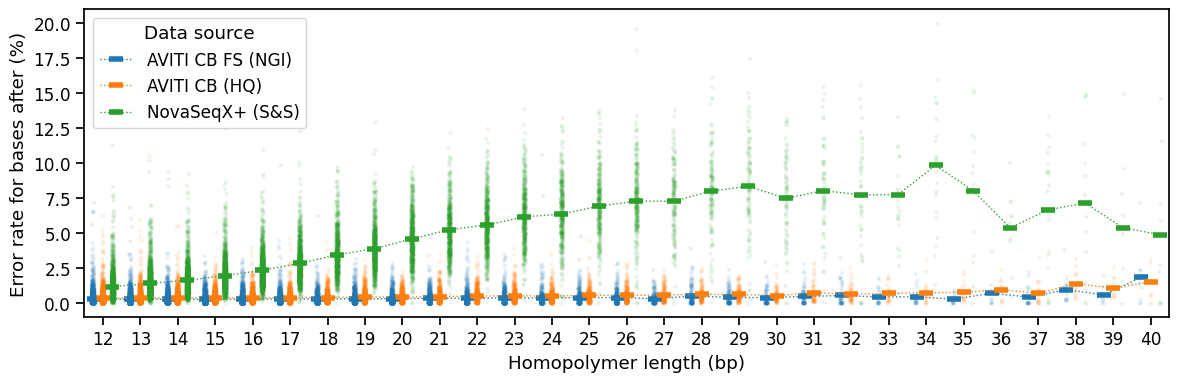

In [175]:
d = dint[(dint["length"] <= 40) & (dint["stratification"] == "homopolymer_ge12")]
fig, ax = plt.subplots(figsize=(14,4))
ax = sns.stripplot(d, x="length", y="error_rate_after", hue="Data source", ax=ax, hue_order=run_names.values(), alpha=0.1, s=3, dodge=True, legend=False)
ax = sns.pointplot(d, x="length", y="error_rate_after", hue="Data source", ax=ax, hue_order=run_names.values(), dodge=0.5, linestyle=":", linewidth=1, errorbar=None,
    marker="_", markersize=10, markeredgewidth=4)
ax.set_ylabel("Error rate for bases after (%)")
ax.set_xlabel("Homopolymer length (bp)")
ax.set_ylim(-1, 21)

Text(0.5, 0, 'Homopolymer length (bp)')

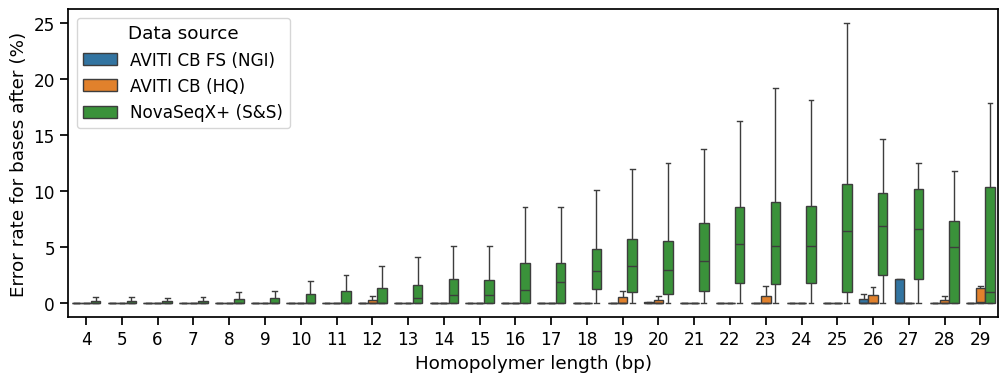

In [129]:
d = dint[(dint["length"] < 30) & (dint["stratification"] == "homopolymer_ge4")]
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.boxplot(d, x="length", y="error_rate_after", hue="Data source", showfliers=False, ax=ax, hue_order=run_names.values())
ax.set_ylabel("Error rate for bases after (%)")
ax.set_xlabel("Homopolymer length (bp)")

Text(0.5, 0, 'Dinucleotide repeat length (bp)')

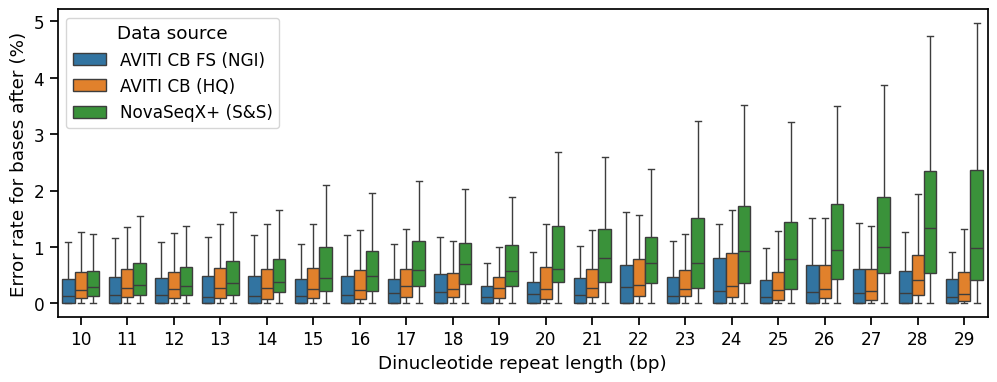

In [130]:
d = dint[(dint["length"] < 30) & (dint["stratification"] == "diTR_10to49")]
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.boxplot(d, x="length", y="error_rate_after", hue="Data source", showfliers=False, ax=ax, hue_order=run_names.values())
ax.set_ylabel("Error rate for bases after (%)")
ax.set_xlabel("Dinucleotide repeat length (bp)")

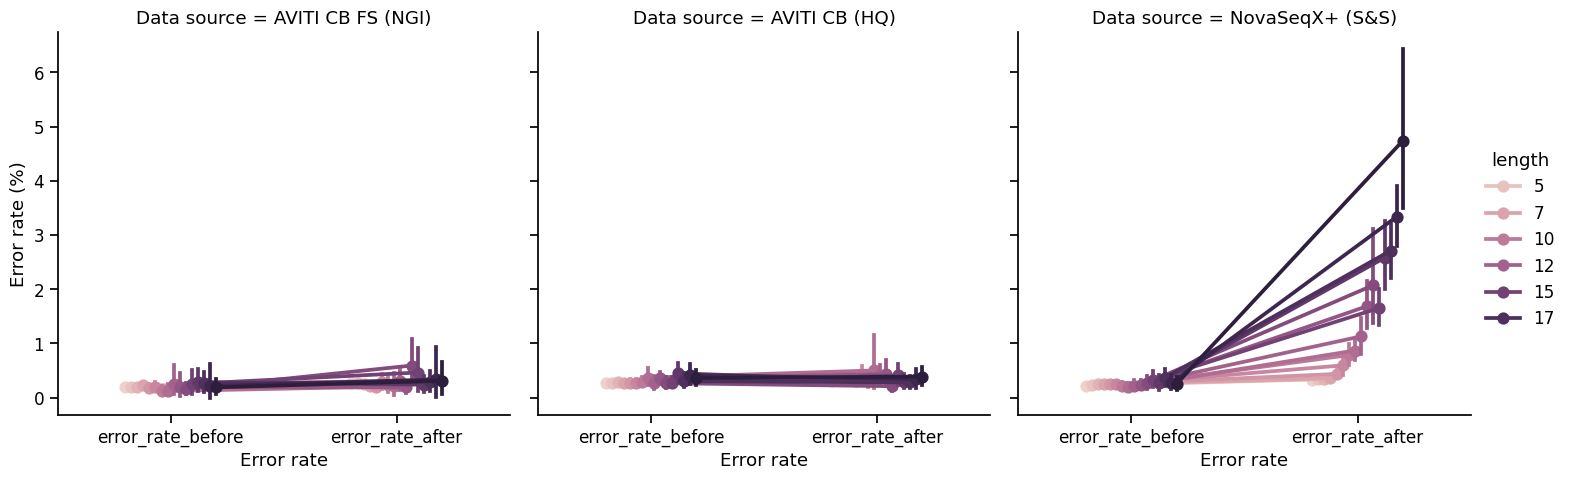

In [70]:
d = dint[(dint["stratification"] == "homopolymer_ge4") & (dint["length"] < 20)]
d = d.melt(id_vars=["interval", "Data source", "length"], value_vars=["error_rate_before", "error_rate_after"], var_name="Error rate", value_name="Error rate (%)")
sns.catplot(d, x="Error rate", y="Error rate (%)", kind="point", dodge=True, hue="length", col="Data source", col_order=run_names.values())

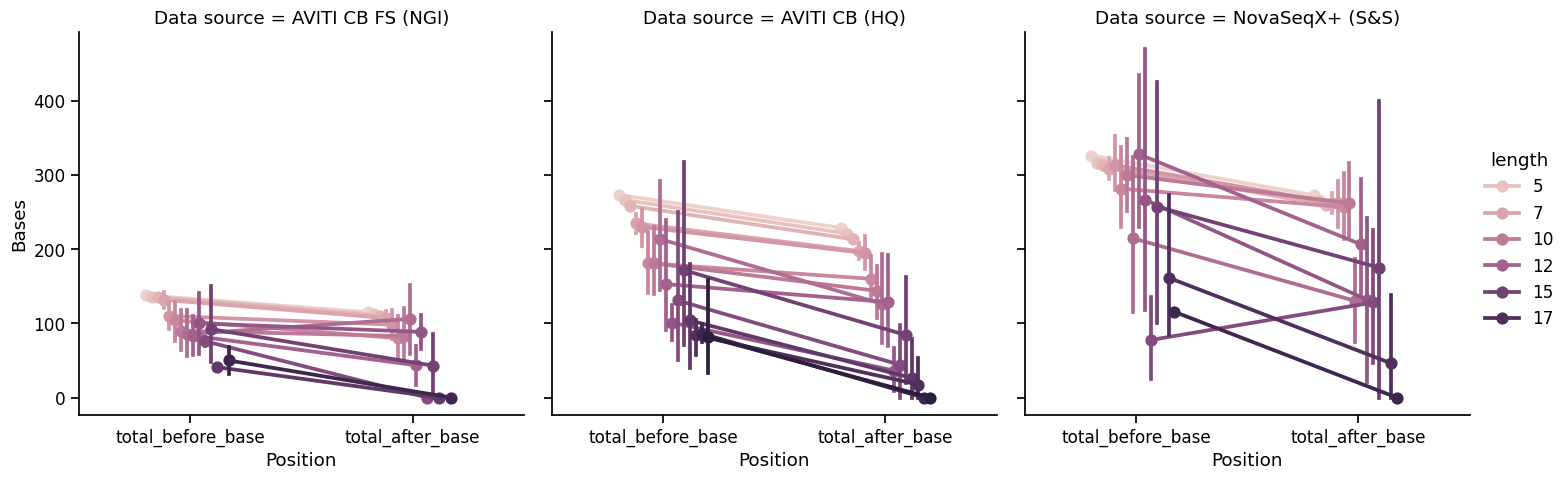

In [73]:
d = dint[(dint["stratification"] == "homopolymer_ge4_GC") & (dint["length"] < 20)]
d = d.melt(id_vars=["interval", "Data source", "length"], value_vars=["total_before_base", "total_after_base"], var_name="Position", value_name="Bases")
sns.catplot(d, x="Position", y="Bases", kind="point", dodge=True, hue="length", col="Data source", col_order=run_names.values())

In [112]:
d = dint[
    (dint["stratification"] == "homopolymer_ge12") &\
    (dint["total_before_base"] > 1000) &\
    (dint["total_after_base"] > 1000)
]


d = d.pivot(index="interval_coord", columns="Data source", values="error_rate_after")
d = d.dropna()
d["ratio"] = d["NovaSeqX+ (S&S)"] / d[["AVITI CB (HQ)", "AVITI CB FS (NGI)"]].mean(axis=1)
d = d.sort_values("ratio", ascending=False)

for i in np.linspace(0, len(d)-1, 10): 
    print(i/len(d))
    print(d.iloc[int(i),:].T)
    print()

0.0
Data source
AVITI CB (HQ)        0.000000
AVITI CB FS (NGI)    0.000000
NovaSeqX+ (S&S)      2.368733
ratio                     inf
Name: chr20:32545950-32545965, dtype: float64

0.11105241533133768
Data source
AVITI CB (HQ)         0.000000
AVITI CB FS (NGI)     0.089286
NovaSeqX+ (S&S)       1.808950
ratio                40.520470
Name: chr20:43577648-43577661, dtype: float64

0.22210483066267536
Data source
AVITI CB (HQ)         0.111049
AVITI CB FS (NGI)     0.076453
NovaSeqX+ (S&S)       1.878736
ratio                20.039636
Name: chr20:14072934-14072948, dtype: float64

0.3331572459940131
Data source
AVITI CB (HQ)         0.353607
AVITI CB FS (NGI)     0.058893
NovaSeqX+ (S&S)       2.696420
ratio                13.073565
Name: chr20:56578360-56578379, dtype: float64

0.4442096613253507
Data source
AVITI CB (HQ)        0.097119
AVITI CB FS (NGI)    0.086133
NovaSeqX+ (S&S)      0.841515
ratio                9.184263
Name: chr20:32735231-32735243, dtype: float64

0.555262076

In [113]:
d = dint[
    (dint["stratification"] == "homopolymer_ge12") &\
    (dint["total_before_base"] > 1000) &\
    (dint["total_after_base"] > 1000)
]


d = d.pivot(index="interval_coord", columns="Data source", values="error_rate_after")
d = d.dropna()
d["ratio"] = d["NovaSeqX+ (S&S)"] / d[["AVITI CB (HQ)", "AVITI CB FS (NGI)"]].mean(axis=1)
d = d.sort_values("ratio", ascending=False)
for i in np.linspace(0, len(d)-1, 10): 
    print(d.iloc[int(i)])

Data source
AVITI CB (HQ)        0.000000
AVITI CB FS (NGI)    0.000000
NovaSeqX+ (S&S)      2.368733
ratio                     inf
Name: chr20:32545950-32545965, dtype: float64
Data source
AVITI CB (HQ)         0.000000
AVITI CB FS (NGI)     0.089286
NovaSeqX+ (S&S)       1.808950
ratio                40.520470
Name: chr20:43577648-43577661, dtype: float64
Data source
AVITI CB (HQ)         0.111049
AVITI CB FS (NGI)     0.076453
NovaSeqX+ (S&S)       1.878736
ratio                20.039636
Name: chr20:14072934-14072948, dtype: float64
Data source
AVITI CB (HQ)         0.353607
AVITI CB FS (NGI)     0.058893
NovaSeqX+ (S&S)       2.696420
ratio                13.073565
Name: chr20:56578360-56578379, dtype: float64
Data source
AVITI CB (HQ)        0.097119
AVITI CB FS (NGI)    0.086133
NovaSeqX+ (S&S)      0.841515
ratio                9.184263
Name: chr20:32735231-32735243, dtype: float64
Data source
AVITI CB (HQ)        0.000000
AVITI CB FS (NGI)    0.194175
NovaSeqX+ (S&S)      0.623

In [115]:
d = dint[
    (dint["stratification"] == "homopolymer_ge4_GC") #&\
    #(dint["total_before_base"] > 1000) &\
    #(dint["total_after_base"] > 1000)
]


d = d.pivot(index="interval_coord", columns="Data source", values="error_rate_after")
d = d.dropna()
d["ratio"] = d["NovaSeqX+ (S&S)"] / d[["AVITI CB (HQ)", "AVITI CB FS (NGI)"]].mean(axis=1)
d = d.sort_values("ratio", ascending=False)
for i in np.linspace(0, len(d)-1, 5): 
    print(d.iloc[int(i)])

Data source
AVITI CB (HQ)        0.000000
AVITI CB FS (NGI)    0.000000
NovaSeqX+ (S&S)      0.943396
ratio                     inf
Name: chr20:31555738-31555742, dtype: float64
Data source
AVITI CB (HQ)        0.438596
AVITI CB FS (NGI)    0.000000
NovaSeqX+ (S&S)      0.558659
ratio                2.547486
Name: chr20:2654957-2654961, dtype: float64
Data source
AVITI CB (HQ)        4.032258
AVITI CB FS (NGI)    0.000000
NovaSeqX+ (S&S)      0.000000
ratio                0.000000
Name: chr20:16681705-16681709, dtype: float64
Data source
AVITI CB (HQ)        0.0
AVITI CB FS (NGI)    0.0
NovaSeqX+ (S&S)      0.0
ratio                NaN
Name: chr20:3423318-3423322, dtype: float64
Data source
AVITI CB (HQ)        0.0
AVITI CB FS (NGI)    0.0
NovaSeqX+ (S&S)      0.0
ratio                NaN
Name: chr20:999463-999467, dtype: float64


In [117]:
dint[dint["interval_coord"] == "chr20:16681705-16681709"]

interval           interval_coord  before_coverage  \
123644      70191  chr20:16681705-16681709                4   
305534      70191  chr20:16681705-16681709                2   
972114     256451  chr20:16681705-16681709                1   
1267497     70191  chr20:16681705-16681709                1   

         total_before_error  total_before_base  error_rate_before  \
123644                    0                238                0.0   
305534                    0                156                0.0   
972114                    0                115                0.0   
1267497                   0                 11                0.0   

         after_coverage  total_after_error  total_after_base  \
123644                4                  0               302   
305534                2                  0               114   
972114                1                  0                20   
1267497               1                  5               124   

         error_rate_after        run      stratification  length  \
123644           0.000000  xplus_sns  homopolymer_ge4_GC       4   
305534           0.000000  aviti_ngi  homopolymer_ge4_GC       4   
972114           0.000000  aviti_ngi     homopolymer_ge4       4   
1267497          4.032258   aviti_hq  homopolymer_ge4_GC       4   

               Data source  
123644     NovaSeqX+ (S&S)  
305534   AVITI CB FS (NGI)  
972114   AVITI CB FS (NGI)  
1267497      AVITI CB (HQ)